# Figure 2: bistability plot for the mean-field model, $\phi=[0.1,1]$ versus invasion threshold $N_w(0)/N_0$

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

Importing required libraries

In [85]:
from scipy.optimize import fsolve
from scipy.integrate import odeint, solve_ivp
import numpy as np
import time
import pandas as pd
import sympy as sp
import math
import pylab as plt
import matplotlib
from sklearn import svm

Importing required scripts

In [87]:
import importlib
import Hughes_model

Hughes_ODEs = Hughes_model.Hughes_ODEs  # defining ODE function (mean-field model Hughes(2013))
F = Hughes_model.F#_hughes   # defining Dye's larval density function

# scripts autosave, so no need to re-run code chunk after making changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Parameter values

In [88]:
days = 2000                          # no. of days in simulation
tStart, tEnd = 0, days               # start time and end time (days) of simulation
tEval = np.linspace(tStart, tEnd)    # output points

Q = 30                   # reproductive carrying capacity
d = 12/100               # per capita death rate
v = 10/10                # probability of vertical transmission of Wolbachia
u = 10/10                # probability that infected male and uninfected female produce inviable offspring
delta = 1                # ratio of Wolbachia-infected death rate versus wild-type
dw = delta*d             # Wolbachia-positive death rate

k = 0.3                  # mosquito competition parameter
h = 0.19*100**k          # other mosquito competition parameter
b = round(d/F(10,h,k,Q),2) # birth rate fitted for Dye's larval density function

sep = 500              # number of points evaluate over invasion threshold range

Using the MATLAB data to find the invasion threshold / basins of attraction boundary and stability as vary $\phi$

*First make sure have run the MATLAB code for the correct parameter values

no invasion threshold found for phi =  0.0
no invasion threshold found for phi =  0.05
no invasion threshold found for phi =  0.1
no invasion threshold found for phi =  0.15000000000000002
no invasion threshold found for phi =  0.2
no invasion threshold found for phi =  0.25
no invasion threshold found for phi =  0.30000000000000004
no invasion threshold found for phi =  0.35000000000000003
no invasion threshold found for phi =  0.4
no invasion threshold found for phi =  0.45
no invasion threshold found for phi =  0.5
no invasion threshold found for phi =  0.55
no invasion threshold found for phi =  0.6000000000000001
no invasion threshold found for phi =  0.65
The intersection point is at (7.003454782928993, 2.9965452170710067)
The intersection point is at (7.499908217117344, 2.500091782882656)
The intersection point is at (8.002545558999973, 1.997454441000027)
The intersection point is at (8.500691420621337, 1.4993085793786634)
The intersection point is at (8.997334760133805, 1.00266

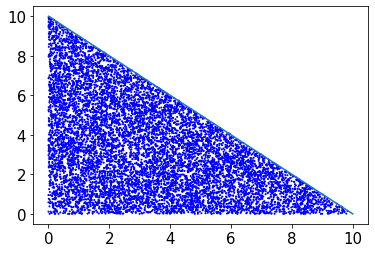

In [89]:

phivec = np.arange(0,1.05,0.05)  # Wolbachia fitness range
inv_thresh = np.zeros(len(phivec))  # invasion threshold array

for i in range(len(phivec)):   # looping over the Wolbachia fitness values
    
    file_name = f'res_detail_qu_{i+1}.csv'  # file name for the data correspoding to the current phi value
    df = pd.read_csv(file_name)          # reading the data file as a pandas dataframe
    phi = phivec[i]                   # current phi value
    
    # color coding the data points based on the invasion outcome
    colors = ['red' if x == 'M0' else 'blue' for x in df['res_detail3']] 
    # plotting the coloured data points
    plt.scatter(df['res_detail1_1'], df['res_detail1_2'], c=colors, s=1)

    xx = np.linspace(0,10,100)  # x values for plotting the line
    plt.plot(xx,10-xx)          # plotting the line y = 10-x, on this line the total population is 10

    # Create a new column where 'y1' is 1 and other values are -1
    df['color'] = [1 if x == 'M0' else -1 for x in df['res_detail3']]
    if all(df['color'] == 1) or all(df['color'] == -1):  # if all points are of the same class, no need to fit SVM
        print('no invasion threshold found for phi = ', phi)  # this means W-invasion not possible or occurs for all
        continue     # don't need to fit SVM model, go to the next phi value
    # Fit the SVM model
    clf = svm.SVC(kernel='linear', C=1000)   # fitting a straight line between the two colours i.e. whether
    clf.fit(df[['res_detail1_1', 'res_detail1_2']], df['color'])   # the invasion occurs or not
    # Get the separating hyperplane
    w = clf.coef_[0]   # coefficients of the separating hyperplane
    a = -w[0] / w[1]

    if a <= 0:   # if the line is parallel to the x-axis, no intersection point
        print('no invasion threshold found for phi = ', phi)
    else:   # plot the separating hyperplane and find the intersection point with the line y = 10-x
        xx = np.linspace(min(df['res_detail1_1']), max(df['res_detail1_1']))
        yy = a * xx - (clf.intercept_[0]) / w[1]

        # Plot the line
        plt.plot(xx, yy, 'k-')

        # Find the intersection point, this will give the invasion threshold
        # Solve for x
        x_intersect = (10 + (clf.intercept_[0]) / w[1]) / (1 + a)

        # Substitute x into the first equation to get y
        y_intersect = 10 - x_intersect

        # Round the coordinates to the nearest integer
        #x_intersect_rounded = round(x_intersect)
        #y_intersect_rounded = round(y_intersect)
        inv_thresh[i] = y_intersect/10   # record invasion threshold i.e. proportion of infected mosquitoes
        # print the invasion threshold
        print(f'The intersection point is at ({x_intersect}, {y_intersect})')
    # Clear the current figure
    plt.clf()



Plotting the figure of the stability and invasion threshold

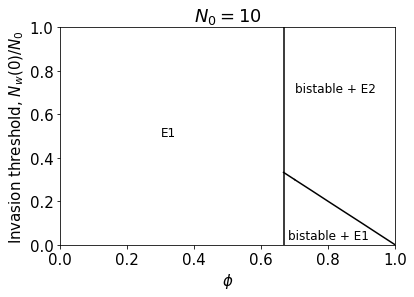

In [108]:
plt.plot(phivec[14:],inv_thresh[14:], 'k')  # only plot for phi > d/b
plt.axvline(d/b, color='black')  # plot bound for Wolbachia only state no longer existing below

# x,y labels
plt.xlabel('$\phi$')
plt.ylabel('Invasion threshold, $N_w(0)/N_0$')

# labelling the regions of attraction and stability
plt.text(0.7,0.7, 'bistable + E2', fontsize = 12) # labelling the regions of attraction and stability
plt.text(0.68,0.025, 'bistable + E1', fontsize = 12)
plt.text(0.3,0.5, 'E1' , fontsize = 12)

# title
plt.title('$N_0=10$')
plt.ylim(0,1) # x,y limits
plt.xlim(0,1)

# we extend from the last invasion threshold data point to the known boundary d/b
# Calculate the slope and intercept of the line
slope, intercept = np.polyfit(phivec[14:], inv_thresh[14:], 1)
# Create an array of x values that extends to d/b
x_extended = np.linspace(min(phivec[14:]), d/b, 100)
# Calculate the corresponding y values
y_extended = slope * x_extended + intercept
# Plot the line
plt.plot(x_extended, y_extended, 'k')
#plt.savefig('Invasion_threshold_v1_wild10_updated.pdf', bbox_inches='tight')  # save figure

Save the invasion theshold data so can overlay on stochastic equivalent figures

In [109]:
np.save('invasion_thresh.npy',inv_thresh)
np.save('invasion_thresh_extended.npy',y_extended)